
# 🤚 Hand Sign Recognition with CNN

This interactive notebook demonstrates how to recognize **10 different hand signs** using a **Convolutional Neural Network (CNN)** built with TensorFlow and Keras.

The model is trained on preprocessed image data from `.h5` datasets. After training, you can also test the model on your own hand sign images.

---

## 📌 What You'll Find in This Notebook

1. 📂 Loading `.h5` training and testing datasets
2. 🧼 Preprocessing the data
3. 🧠 Building a CNN model with Keras
4. 🏋️ Training the model and plotting metrics
5. 📊 Evaluating performance on the test set
6. 🔍 Predicting custom hand sign images

---


# Hand Sign Recognition with CNN

This notebook implements a Convolutional Neural Network (CNN) for recognizing hand signs from images using TensorFlow and Keras. The model is trained on a dataset of labeled sign images stored in `.h5` format. The project walks through data loading, preprocessing, model architecture, training, evaluation, and custom prediction.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers

## 0. Load Dataset

In [4]:
def load_signs_dataset():
    train_dataset = h5py.File('./datasets/train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('./datasets/test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [5]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_signs_dataset()

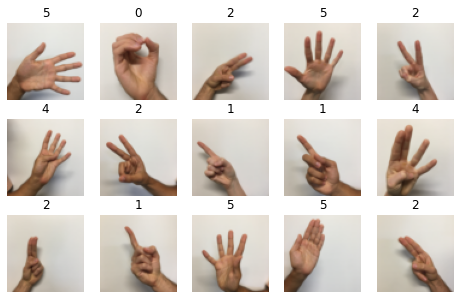

In [6]:
plt.figure(figsize=(8, 5))
for i in range(15):
    ax = plt.subplot(3, 5, i + 1)
    plt.imshow(X_train_orig[i])
    plt.title(np.squeeze(Y_train_orig[:, i]))
    plt.axis("off")

## 1. Prepare Dataset

#### One hot encoding

In [7]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

In [8]:
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T

#### Normalize image

In [9]:
X_train = X_train_orig/255.
X_test = X_test_orig/255.

In [10]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


## 2. Model

In [11]:

def convolutional_model(input_shape):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> DENSE
    
    Note that for simplicity and grading purposes, you'll hard-code some values
    such as the stride and kernel (filter) sizes. 
    Normally, functions should take these values as function parameters.
    
    Arguments:
    input_img -- input dataset, of shape (input_shape)

    Returns:
    model -- TF Keras model (object containing the information for the entire training process) 
    """
    

    input_img = tf.keras.Input(shape=input_shape)
    
    ## CONV2D: 8 filters 4x4, stride of 1, padding 'SAME', activation 'relu'
    A1 = layers.Conv2D(filters = 8, kernel_size = 4, strides=(1,1), padding='same', activation='relu')(input_img)
    
    ## MAXPOOL: window 8x8, stride 8, padding 'SAME'
    P1 = layers.MaxPool2D(pool_size=(8, 8), strides=(8,8), padding='same')(A1)
    
    ## CONV2D: 16 filters 2x2, stride 1, padding 'SAME', activation 'relu'
    A2 = layers.Conv2D(filters = 16, kernel_size = 2, strides=(1,1), padding='same', activation='relu')(P1)
    
    ## MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = layers.MaxPool2D(pool_size=(4, 4), strides=(4,4), padding='same')(A2)
    
    ## FLATTEN layers.Flatten()
    F = layers.Flatten()(P2)
    
    ## Dense layer
    ## 6 neurons in output layer. Hint: one of the arguments should be "activation='softmax'" 
    outputs = layers.Dense(units=6, activation='softmax')(F)

    model = tf.keras.Model(inputs=input_img, outputs=outputs)
    
    return model
            

In [12]:
conv_model = convolutional_model((64, 64, 3))
conv_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
conv_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 8)         392       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 8, 8, 8)          0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 16)          528       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 2, 2, 16)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 64)                0     

In [13]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).batch(64)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).batch(64)

In [14]:
history = conv_model.fit(train_dataset, epochs=100, validation_data=test_dataset)

Epoch 1/100
17/17 [==============================] - 1s 27ms/step - loss: 1.7900 - accuracy: 0.1667 - val_loss: 1.7859 - val_accuracy: 0.2500
Epoch 2/100
17/17 [==============================] - 0s 22ms/step - loss: 1.7811 - accuracy: 0.2370 - val_loss: 1.7792 - val_accuracy: 0.2250
Epoch 3/100
17/17 [==============================] - 0s 24ms/step - loss: 1.7736 - accuracy: 0.2463 - val_loss: 1.7712 - val_accuracy: 0.2250
Epoch 4/100
17/17 [==============================] - 0s 22ms/step - loss: 1.7632 - accuracy: 0.2648 - val_loss: 1.7608 - val_accuracy: 0.2917
Epoch 5/100
17/17 [==============================] - 0s 23ms/step - loss: 1.7459 - accuracy: 0.2944 - val_loss: 1.7465 - val_accuracy: 0.3000
Epoch 6/100
17/17 [==============================] - 0s 22ms/step - loss: 1.7255 - accuracy: 0.2981 - val_loss: 1.7285 - val_accuracy: 0.3250
Epoch 7/100
17/17 [==============================] - 0s 21ms/step - loss: 1.6985 - accuracy: 0.3167 - val_loss: 1.7057 - val_accuracy: 0.3500
Epoch 

## 3. Results

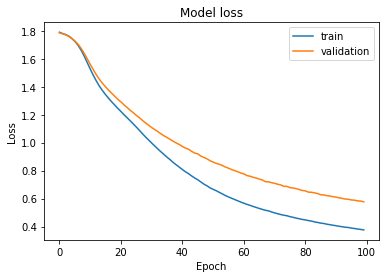

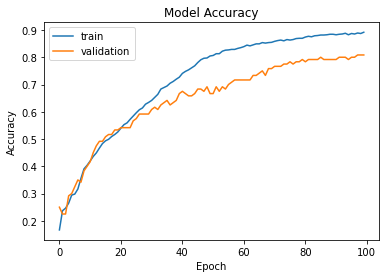

In [15]:
# The history.history["loss"] entry is a dictionary with as many values as epochs that the
# model was trained on. 
df_loss_acc = pd.DataFrame(history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(6,4)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(6,4)).set(xlabel='Epoch',ylabel='Accuracy');

In [16]:
y_pred = conv_model.predict(train_dataset)

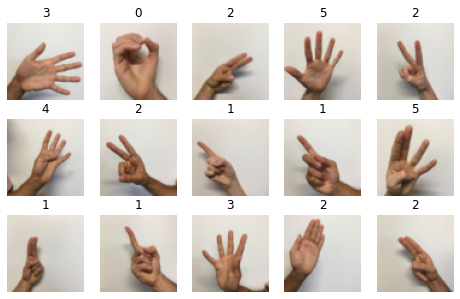

In [17]:
plt.figure(figsize=(8, 5))
for i in range(15):
    ax = plt.subplot(3, 5, i + 1)
    plt.imshow(X_train_orig[i])
    plt.title(np.argmax(y_pred[i]))
    plt.axis("off")

## 4. Test on own images

In [18]:
from PIL import Image

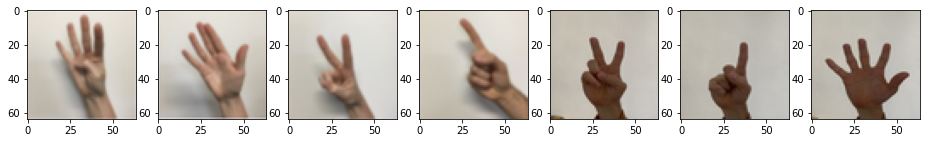

In [19]:
my_test_images = []

IMAGE_SIZE = (64, 64)
NUMBER_OF_IMAGES = 7

plt.figure(figsize=(16, 10))
for i in range(NUMBER_OF_IMAGES):
    # read file
    img = Image.open(f"./test/myimg{i}.jpg").resize(IMAGE_SIZE, Image.ANTIALIAS)
    
    # normalize
    img = np.array(img)/255.
    
    my_test_images.append(img)
    ax = plt.subplot(1, NUMBER_OF_IMAGES, i + 1)
    plt.imshow(my_test_images[i])
    
my_test_images = np.array(my_test_images)

In [20]:
my_test_dataset = tf.data.Dataset.from_tensor_slices(my_test_images).batch(NUMBER_OF_IMAGES)

In [21]:
np.argmax(conv_model.predict(my_test_dataset), axis=1)

array([4, 5, 2, 1, 1, 1, 5], dtype=int64)